Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install .. # installing d2l


# Adadelta
:label:`sec_adadelta`

Adadelta é outra variante do AdaGrad (:numref:`sec_adagrad`). A principal diferença reside no fato de que diminui a quantidade pela qual a taxa de aprendizagem é adaptável às coordenadas. Além disso, tradicionalmente é referido como não tendo uma taxa de aprendizagem, uma vez que usa a quantidade de mudança em si como calibração para mudanças futuras. O algoritmo foi proposto em :cite:`Zeiler.2012`. É bastante simples, dada a discussão de algoritmos anteriores até agora.

## O Algoritmo

Em poucas palavras, Adadelta usa duas variáveis de estado, $\mathbf{s}_t$ para armazenar uma média de vazamento do segundo momento do gradiente e $\Delta\mathbf{x}_t$ para armazenar uma média de vazamento do segundo momento da mudança de parâmetros no próprio modelo. Observe que usamos a notação original e a nomenclatura dos autores para compatibilidade com outras publicações e implementações (não há outra razão real para usar variáveis gregas diferentes para indicar um parâmetro que serve ao mesmo propósito em momentum, Adagrad, RMSProp e Adadelta)

Aqui estão os detalhes técnicos do Adadelta. Dado que o parâmetro du jour é $\rho$, obtemos as seguintes atualizações vazadas de forma semelhante a :numref:`sec_rmsprop`:

$$\begin{aligned}
    \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2.
\end{aligned}$$

A diferença para :numref:`sec_rmsprop` é que realizamos atualizações com o gradiente redimensionado $\mathbf{g}_t'$, ou seja,

$$\begin{aligned}
    \mathbf{x}_t  & = \mathbf{x}_{t-1} - \mathbf{g}_t'. \\
\end{aligned}$$

Então, qual é o gradiente redimensionado $\mathbf{g}_t'$? Podemos calculá-lo da seguinte maneira:

$$\begin{aligned}
    \mathbf{g}_t' & = \frac{\sqrt{\Delta\mathbf{x}_{t-1} + \epsilon}}{\sqrt{{\mathbf{s}_t + \epsilon}}} \odot \mathbf{g}_t, \\
\end{aligned}$$

onde $\Delta \mathbf{x}_{t-1}$ é a média de vazamento dos gradientes redimensionados ao quadrado $\mathbf{g}_t'$. Inicializamos $\Delta \mathbf{x}_{0}$ para ser $0$ e atualizamos em cada etapa com $\mathbf{g}_t'$, ou seja,

$$\begin{aligned}
    \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) {\mathbf{g}_t'}^2,
\end{aligned}$$

e $\epsilon$ (um pequeno valor como $10^{-5}$) é adicionado para manter a estabilidade numérica.


## Implementação

Adadelta precisa manter duas variáveis de estado para cada variável, $\mathbf{s}_t$ e $\Delta\mathbf{x}_t$. Isso produz a seguinte implementação.


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-place updates via [:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

Escolher $\rho = 0,9$ equivale a um tempo de meia-vida de 10 para cada atualização de parâmetro. Isso tende a funcionar muito bem. Obtemos o seguinte comportamento.


loss: 0.244, 0.015 sec/epoch


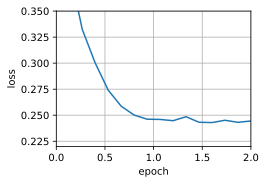

In [2]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

Para uma implementação concisa, simplesmente usamos o algoritmo `adadelta` da classe `Trainer`. Isso produz o seguinte one-liner para uma invocação muito mais compacta.


loss: 0.243, 0.013 sec/epoch


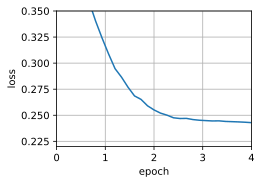

In [3]:
trainer = torch.optim.Adadelta
d2l.train_concise_ch11(trainer, {'rho': 0.9}, data_iter)

## Sumário

* Adadelta não tem parâmetro de taxa de aprendizagem. Em vez disso, ele usa a taxa de mudança nos próprios parâmetros para adaptar a taxa de aprendizado.
* Adadelta requer duas variáveis de estado para armazenar os segundos momentos de gradiente e a mudança nos parâmetros.
* Adadelta usa médias vazadas para manter uma estimativa contínua das estatísticas apropriadas.

## Exercícios

1. Ajuste o valor de $\rho$. O que acontece?
1. Mostre como implementar o algoritmo sem o uso de $\mathbf{g}_t'$. Por que isso pode ser uma boa ideia?
1. A taxa de aprendizagem Adadelta é realmente gratuita? Você conseguiu encontrar problemas de otimização que quebram o Adadelta?
1. Compare Adadelta com Adagrad e RMS prop para discutir seu comportamento de convergência.


[Discussão](https://discuss.d2l.ai/t/1076)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMTE5MDU5OTAzMyw4OTQ3MjgzNzVdfQ==
-->
